In [85]:
import requests
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
zips = pd.read_csv('zipcodes.csv')
df = pd.read_csv('final_data.csv')

In [101]:
zips.head()

,zip,city,state,latitude,longitude,timezone,dst
0,210,Portsmouth,NH,43.005895,-71.013202,-5,1
1,211,Portsmouth,NH,43.005895,-71.013202,-5,1
2,212,Portsmouth,NH,43.005895,-71.013202,-5,1
3,213,Portsmouth,NH,43.005895,-71.013202,-5,1
4,214,Portsmouth,NH,43.005895,-71.013202,-5,1


In [102]:
df = df.dropna(subset=['zip'])
df = df.drop_duplicates(subset=['zip'])

In [103]:
type(df.zip[0])

numpy.float64

In [90]:
df.head()

,mni_no,dedupe_id,dob,sex,race,mar_stat,city,state,zip,case_no,...,bail_amt,bailed_out,pri_dx_value,refferal_source,mh_treatment,re_entry,age,after_released,within_one,within_two
0,494625,131.0,1990-05-31,MALE,WHITE,S,OLATHE,KS,66062.0,11CR02750,...,NaN,0,UNSPECIFIED AFFECTIVE PSYCHOSIS,NaN,0,1,22.0,138.0,1,1
3,673675,309.0,1978-04-07,MALE,WHITE,S,OLATHE,KS,66061.0,15DV00382,...,1000.0,1,UNSPECIFIED AFFECTIVE PSYCHOSIS,NaN,0,1,37.0,386.0,0,1
5,380717,619.0,1989-10-25,MALE,WHITE,S,KANSAS CITY,MO,64111.0,12DV00527,...,5000.0,1,PROLONGED POST TRAUMATIC STRESS DISORDER,SELF,1,1,23.0,375.0,0,1
9,670573,655.0,1982-01-28,FEMALE,BLACK OR AFRICAN AMERICAN,S,KANSAS CITY,KS,66101.0,15CR00742,...,10000.0,1,UNSPECIFIED AFFECTIVE PSYCHOSIS,NaN,0,1,33.0,157.0,1,1
11,422785,1017.0,1987-01-28,MALE,WHITE,S,ROELAND PARK,KS,66205.0,14CR00850,...,1500.0,1,UNSPECIFIED AFFECTIVE PSYCHOSIS,NaN,0,1,27.0,1179.0,0,0


In [91]:
df.shape

(1208, 27)

In [92]:
def alter_zip(x):
    x = str(x)
    if len(x)==3:
        x = "00" + x
    return x

In [105]:
def to_lat_lon(table, ziptable):
    ziptable['zip'] = ziptable['zip'].apply(lambda x: alter_zip(x))
    table['zip'] = table['zip'].apply(int)
    table['zip'] = table['zip'].apply(str)
    ziptable = ziptable.drop(['city', 'state','timezone','dst'], axis=1) 
    table = pd.merge(table[["zip"]], ziptable, on ='zip', how="inner")
    return table

In [106]:
def get_fips(table):

    fips = []
    for i, row in table.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(lat,lon)
        r= requests.get(url)
        file = r.json()
        if r:
            code = file['Block']["FIPS"]
            fips.append(code)
        else:
            fips.append(None)
    table['fips'] = fips
    return table

In [107]:
new = to_lat_lon(df, zips)

In [108]:
zips[zips.zip=='00210']

,zip,city,state,latitude,longitude,timezone,dst
0,00210,Portsmouth,NH,43.005895,-71.013202,-5,1


In [109]:
new=new.drop_duplicates(subset=['zip'])

In [110]:
new

,zip,latitude,longitude
0,66062,38.860511,-94.77581
1,66061,38.889784,-94.85558
2,64111,39.056505,-94.59439
3,66101,39.118054,-94.62568
4,66205,39.030172,-94.63097
5,66215,38.961006,-94.74145
6,66202,39.023105,-94.66658
7,64014,39.017559,-94.25767
8,66212,38.959606,-94.68189
9,66053,38.602219,-94.68121


In [111]:
get_fips(new)

,zip,latitude,longitude,fips
0,66062,38.860511,-94.77581,200910535072001
1,66061,38.889784,-94.85558,200910528012016
2,64111,39.056505,-94.59439,290950168004006
3,66101,39.118054,-94.62568,202090418001004
4,66205,39.030172,-94.63097,200910501005009
5,66215,38.961006,-94.74145,200910524171029
6,66202,39.023105,-94.66658,200910503012017
7,64014,39.017559,-94.25767,290950141013015
8,66212,38.959606,-94.68189,200910518033010
9,66053,38.602219,-94.68121,201211004001027


In [122]:
def break_down(table):
    temp = np.array(table['fips'])
    fips = [x for x in temp if x!=None]
    state = [x[:2] for x in temp if x!=None]
    county = [x[2:5] for x in temp if x!=None]
    tract = [x[5:11] for x in temp if x!=None]
    blockgroup = [x[11:12] for x in temp if x!=None]
    fips_df = pd.DataFrame({'fips' : fips, 'state' : state, 'county' : county, 'tract' : tract, 'blockgroup' : blockgroup })
    table = pd.merge(table, fips_df, on = 'fips')
    
    return fips_df

In [123]:
fips_df = break_down(new)

In [124]:
fips_df.shape

(1110, 5)

In [125]:
fips_df.head()

,blockgroup,county,fips,state,tract
0,2,091,200910535072001,20,053507
1,2,091,200910528012016,20,052801
2,4,095,290950168004006,29,016800
3,1,209,202090418001004,20,041800
4,5,091,200910501005009,20,050100


In [126]:
unique_fips = fips_df.drop_duplicates()

In [133]:
unique_fips.shape

(1101, 5)

In [137]:
withfips = pd.merge(new, unique_fips, on = 'fips')

In [138]:
withfips.head()

,zip,latitude,longitude,fips,blockgroup,county,state,tract
0,66062,38.860511,-94.77581,200910535072001,2,091,20,053507
1,66061,38.889784,-94.85558,200910528012016,2,091,20,052801
2,64111,39.056505,-94.59439,290950168004006,4,095,29,016800
3,66101,39.118054,-94.62568,202090418001004,1,209,20,041800
4,66205,39.030172,-94.63097,200910501005009,5,091,20,050100


In [139]:
withfips.shape

(1110, 8)

In [140]:
withfips.head()

,zip,latitude,longitude,fips,blockgroup,county,state,tract
0,66062,38.860511,-94.77581,200910535072001,2,091,20,053507
1,66061,38.889784,-94.85558,200910528012016,2,091,20,052801
2,64111,39.056505,-94.59439,290950168004006,4,095,29,016800
3,66101,39.118054,-94.62568,202090418001004,1,209,20,041800
4,66205,39.030172,-94.63097,200910501005009,5,091,20,050100


In [141]:
def info_retrieve(table):
    asc = []
    for i, row in table.iterrows():
        fips = row['fips']
        blkgrp = row['blockgroup']
        state = row['state']
        county = row['county']
        tract = row['tract']
        
        search_term = 'B19301_001E,B17021_001E,B19001_001E,B25087_001E,B14005_001E,B09002_001E,B19056_001E,B99104_001E,B21002_001E,B15002_001E,B25075_001E,B19059_001E,B25070_001E'
        key = '209a50c6b62ff53a635f9ae4a6e6cc5d3467c7d7'
        address = 'https://api.census.gov/data/2010/acs5?get={}&for=block+group:{}&in=state:{}+county:{}+tract:{}&key={}'.format(search_term, blkgrp, state, county, tract, key)
 
        json_results = requests.get(address)
        json_dict = json_results.json()
        
        if json_results:
            info = [fips] + json_dict[1]
            asc.append(info)
        else:
            asc.append([None]*len(json_dict[1]))

            
        print("getting...")
            
    colnames = ['fips','per_capita_income', 'poverty_stat', 'household_income', 'mortgage_stat', 'school_enrollment_16-19', 'own_children_under18', 'SSI_income', 'grandparent_care', 'military_service', 'education_25', 'property_value_occupied', 'retirement_income', 'rent_over_income', 'state', 'county', 'tract', 'blockgroup']
    print("writing to the dataframe")
    asc_df = pd.DataFrame(asc, columns = colnames)
    unique_asc = asc_df.drop_duplicates()
    
    #total_df = pd.merge(table, unique_asc, left_on = 'fips', right_on = 'fips')
    
    return unique_asc

In [142]:
test = withfips[:10]

In [143]:
test_asc = info_retrieve(test)

getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
writing to the dataframe


In [144]:
test_asc

,fips,per_capita_income,poverty_stat,household_income,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income,state,county,tract,blockgroup
0,200910535072001,29721,1177,407,371,59,327,407,706,91,773,371,407,36,20,091,053507,2
1,200910528012016,36605,1571,475,461,82,576,475,847,77,958,461,475,14,20,091,052801,2
2,290950168004006,31496,1210,811,110,0,31,811,634,111,981,110,811,701,29,095,016800,4
3,202090418001004,11478,985,626,31,25,67,626,717,95,745,31,626,595,20,209,041800,1
4,200910501005009,29905,1108,420,398,35,266,420,698,87,752,398,420,22,20,091,050100,5
5,200910524171029,24855,2436,1130,127,158,630,1130,1202,143,1571,127,1130,1003,20,091,052417,1
6,200910503012017,32814,737,437,254,0,21,437,606,154,622,254,437,183,20,091,050301,2
7,290950141013015,23644,1772,640,331,111,453,640,1009,166,1146,331,640,309,29,095,014101,3
8,200910518033010,26836,1118,456,364,167,175,456,692,66,776,364,456,92,20,091,051803,3
9,201211004001027,32183,1432,556,504,12,380,556,996,199,1052,504,556,52,20,121,100400,1


In [145]:
unique_asc = info_retrieve(withfips)

getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...

getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...
getting...

In [146]:
unique_asc.head()

,fips,per_capita_income,poverty_stat,household_income,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income,state,county,tract,blockgroup
0,200910535072001,29721,1177,407,371,59,327,407,706,91,773,371,407,36,20,091,053507,2
1,200910528012016,36605,1571,475,461,82,576,475,847,77,958,461,475,14,20,091,052801,2
2,290950168004006,31496,1210,811,110,0,31,811,634,111,981,110,811,701,29,095,016800,4
3,202090418001004,11478,985,626,31,25,67,626,717,95,745,31,626,595,20,209,041800,1
4,200910501005009,29905,1108,420,398,35,266,420,698,87,752,398,420,22,20,091,050100,5


In [147]:
unique_asc.to_csv("unique_asc.csv")

In [148]:
unique_asc.shape

(1101, 18)

In [156]:
total_df = pd.merge(new, unique_asc, left_on = 'fips', right_on = 'fips')

In [158]:
asc_cols = list(unique_asc.columns)
df_cols = list(total_df.columns)
cols = list(set(asc_cols).difference(set(df_cols)))

unique_asc = unique_asc.drop(cols, axis=1)

In [159]:
total_df.shape

(1110, 17)

In [161]:
total_df.head()

,zip,latitude,longitude,fips,per_capita_income,poverty_stat,household_income,mortgage_stat,school_enrollment_16-19,own_children_under18,SSI_income,grandparent_care,military_service,education_25,property_value_occupied,retirement_income,rent_over_income
0,66062,38.860511,-94.77581,200910535072001,29721,1177,407,371,59,327,407,706,91,773,371,407,36
1,66061,38.889784,-94.85558,200910528012016,36605,1571,475,461,82,576,475,847,77,958,461,475,14
2,64111,39.056505,-94.59439,290950168004006,31496,1210,811,110,0,31,811,634,111,981,110,811,701
3,66101,39.118054,-94.62568,202090418001004,11478,985,626,31,25,67,626,717,95,745,31,626,595
4,66205,39.030172,-94.63097,200910501005009,29905,1108,420,398,35,266,420,698,87,752,398,420,22


In [163]:
def missing_vals(df):

    # make new columns indicating what will be imputed
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    for col in cols_with_missing:
    #df[col + '_was_missing'] = df[col].isnull()
        print('{} has missing values'.format(col))

    return cols_with_missing

In [164]:
missing_vals(total_df)

per_capita_income has missing values


['per_capita_income']

In [179]:
# FILL IN MISSING VALUES WITH SELECTED METHODS FOR EACH TYPE 
def Fill_in(df, cols, method="mean"):
    '''
    Filling in missing values with "mean" or "median"
    
    Inputs:
        df: (pandas dataframe)
        a list of those column names
        method (string): mean or median
 
    Returns:
        pandas dataframe
    '''
    for col in cols:
        if method =='mean':
            val = df[col].mean()
        elif method =='median':
            val = df[col].median()
        elif method =='mode':
            if df[col].dtype == 'object':
                try:
                    df[col].fillna(df[col].mode()[0], inplace=True)
                except:
                    df[col].fillna("")
        elif method == 'missing':
            val = "missing"
            df[col] = df[col].fillna(val)
        print ('Filling missing value for {} using {}'.format(col, method))
    return df

In [180]:
total_df =Fill_in(total_df, ["per_capita_income"] , "median")

Filling missing value for per_capita_income using median


In [165]:
total_df.isnull().sum()

zip                        0
latitude                   0
longitude                  0
fips                       0
per_capita_income          3
poverty_stat               0
household_income           0
mortgage_stat              0
school_enrollment_16-19    0
own_children_under18       0
SSI_income                 0
grandparent_care           0
military_service           0
education_25               0
property_value_occupied    0
retirement_income          0
rent_over_income           0
dtype: int64

In [166]:
def plot_df(df, columns, save=False):

    for col in columns:
        count_column = df[col].value_counts()
        plt.figure(figsize=(len(count_column), 5))
        column_figure = sns.barplot(count_column.index, count_column.values, alpha=0.8)
        plt.title('{} values'.format(col))
        plt.ylabel('Number of Counts', fontsize=12)
        plt.xlabel(col, fontsize=12) 

        if save: 
            column_figure.figure.savefig('{}.png'.format(col))
            print('figure is saved as a file ~.png')
        else:
            plt.show()
    return None

In [181]:
df.columns

Index(['mni_no', 'dedupe_id', 'dob', 'sex', 'race', 'mar_stat', 'city',
       'state', 'zip', 'case_no', 'case_type', 'booking_no',
       'arresting_agency', 'arresting_agency_type', 'booking_date',
       'release_date', 'bail_type', 'bail_amt', 'bailed_out', 'pri_dx_value',
       'refferal_source', 'mh_treatment', 're_entry', 'age', 'after_released',
       'within_one', 'within_two'],
      dtype='object')

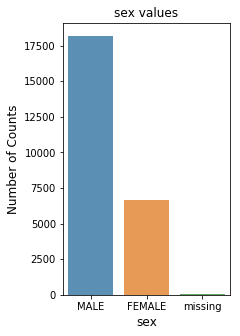

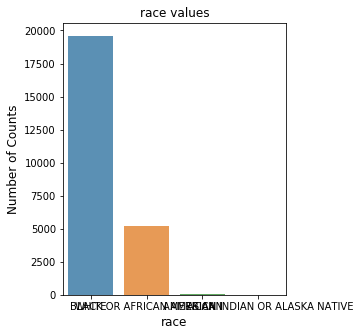

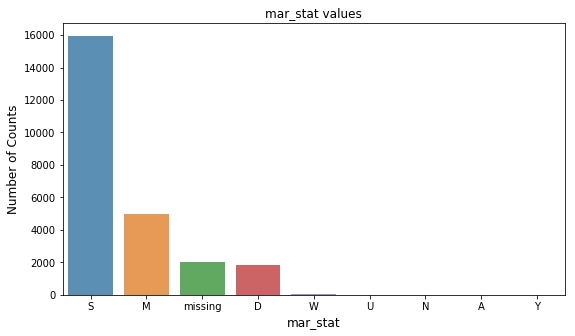

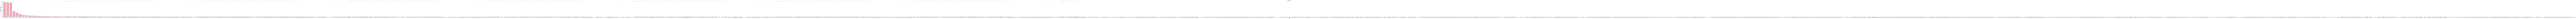

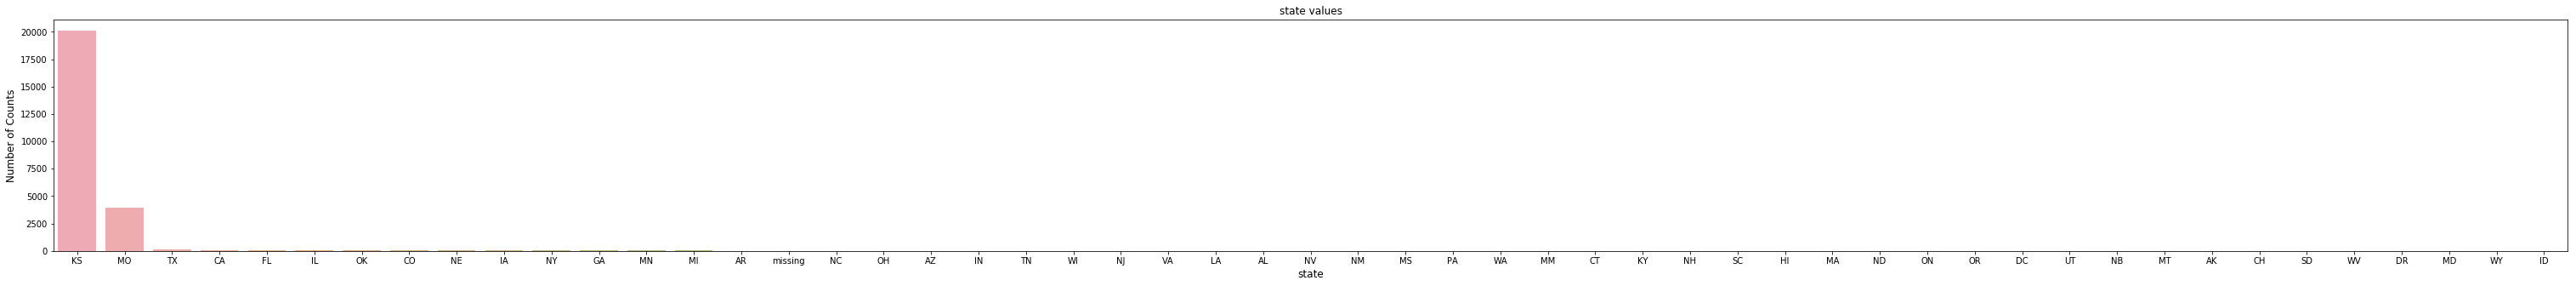

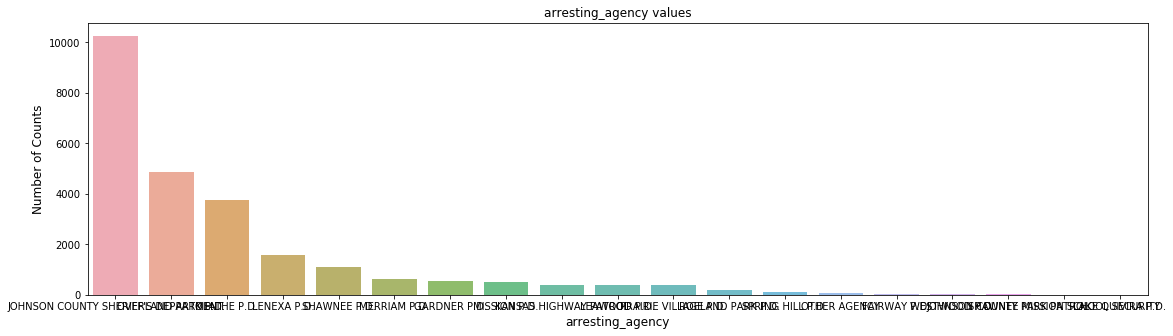

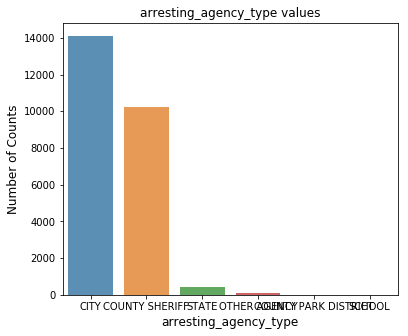

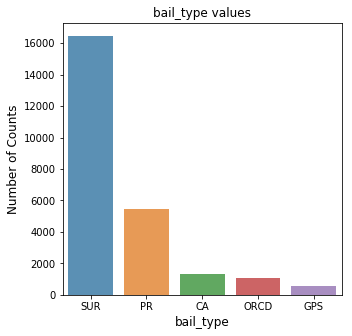

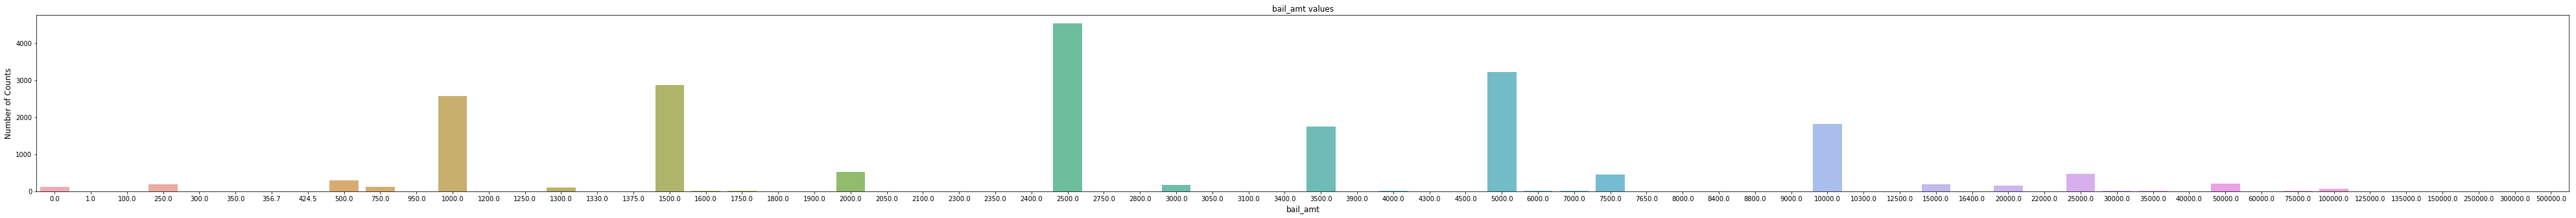

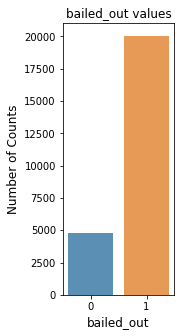

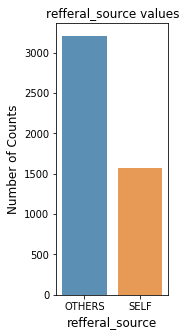

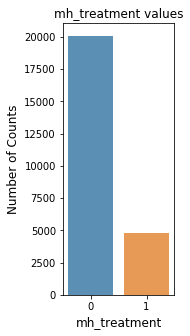

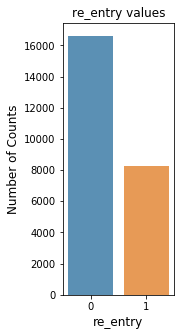

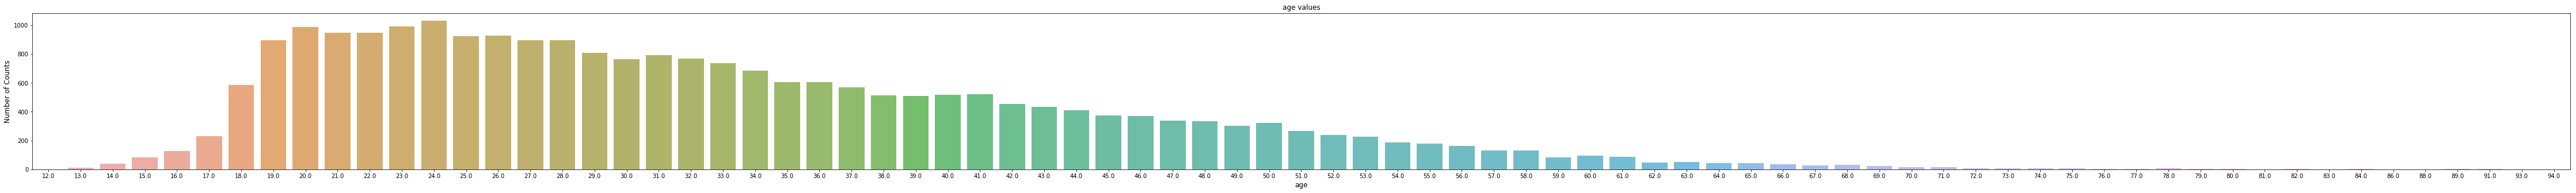

In [183]:
plot_df(df,['sex', 'race', 'mar_stat', 'city', 'state', 'arresting_agency', 'arresting_agency_type','bail_type', 'bail_amt', 'bailed_out','refferal_source', 'mh_treatment','re_entry', 'age'])

In [170]:
total_df.nunique()

zip                        1110
latitude                   1101
longitude                  1099
fips                       1101
per_capita_income          1066
poverty_stat                874
household_income            621
mortgage_stat               588
school_enrollment_16-19     242
own_children_under18        540
SSI_income                  621
grandparent_care            754
military_service            302
education_25                775
property_value_occupied     588
retirement_income           621
rent_over_income            420
dtype: int64

In [182]:
total_df.to_csv('fips_acs.csv', index=False)